In [32]:
from kan import KAN
import torch
import torch.nn as nn

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [33]:
# kan_architecture=[2,3,n_classes]
# kan_architecture=[2,3,3,3,3,3,n_classes]

class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Dataset Args
n_classes = 2**2
m = 10
n_epochs = 500
hidden = [5]*5
architecture = [2] + hidden + [n_classes]

print(architecture)



args_dict = {
    'seed': 2024,
    'base_fun': "silu",
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
}
args = Args(**args_dict)

[2, 5, 5, 5, 5, 5, 4]


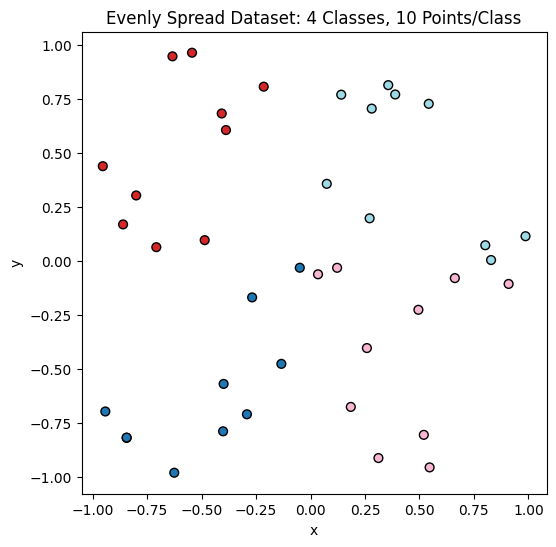

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def create_evenly_spread_dataset(n_classes=32, m=3, bounds=(-1, 1), seed=42):
    np.random.seed(seed)
    # Compute grid size (try to make it as square as possible)
    grid_size = int(np.ceil(np.sqrt(n_classes)))
    x_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    y_edges = np.linspace(bounds[0], bounds[1], grid_size + 1)
    data = []
    labels = []
    class_idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if class_idx >= n_classes:
                break
            x_min, x_max = x_edges[i], x_edges[i+1]
            y_min, y_max = y_edges[j], y_edges[j+1]
            # Sample m points uniformly within this cell
            xs = np.random.uniform(x_min, x_max, size=(m, 1))
            ys = np.random.uniform(y_min, y_max, size=(m, 1))
            points = np.hstack([xs, ys])
            data.append(points)
            labels.extend([class_idx] * m)
            class_idx += 1
        if class_idx >= n_classes:
            break
    data = np.vstack(data)
    labels = np.array(labels)
    return data, labels


data, labels = create_evenly_spread_dataset(n_classes=n_classes, m=m, bounds=(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab20', edgecolor='k', s=40)
plt.title(f'Evenly Spread Dataset: {n_classes} Classes, {m} Points/Class')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

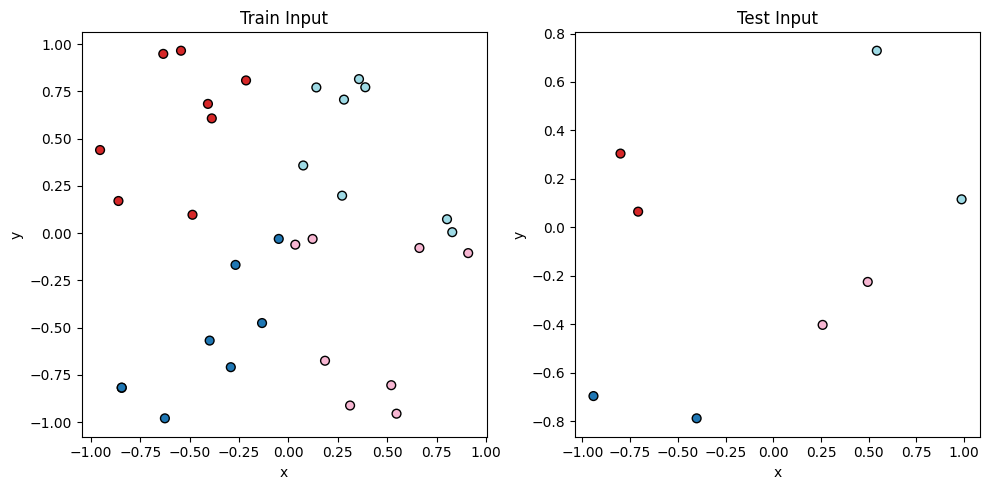

In [35]:
from sklearn.model_selection import train_test_split

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

# Split data and labels into train/test sets

train_input, test_input, train_label, test_label = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [36]:
class ReLUMLP(nn.Module):
    def __init__(self, n_hidden=32, n_classes=2, depth=3):
        super().__init__()
        layers = [nn.Linear(2, n_hidden), nn.ReLU()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(n_hidden, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

mlp = ReLUMLP(n_hidden=16, n_classes=n_classes, depth=3).to(device)
print("MLP")
print(mlp)

MLP
ReLUMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
)


# Normal MLP & KAN Training

In [37]:
import torch.nn.functional as F

def train_model(model, optimizer, dataset, n_epochs=100, log_interval=10):
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    train_accs, test_accs, train_losses, test_losses = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = F.cross_entropy(output, train_label)
        loss.backward()
        optimizer.step()

        # Logging
        model.eval()
        with torch.no_grad():
            train_pred = model(train_input).argmax(dim=1)
            test_pred = model(test_input).argmax(dim=1)
            train_acc = (train_pred == train_label).float().mean().item()
            test_acc = (test_pred == test_label).float().mean().item()
            train_loss = F.cross_entropy(model(train_input), train_label).item()
            test_loss = F.cross_entropy(model(test_input), test_label).item()
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        if (epoch+1) % log_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

    return {
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_losses': train_losses,
        'test_losses': test_losses
    }


In [38]:
# Train MLP
mlp_opt = torch.optim.Adam(mlp.parameters(), lr=args.learning_rate)
mlp_logs = train_model(mlp, mlp_opt, dataset, n_epochs=n_epochs)

Epoch 1/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.384 | Test Loss: 1.384
Epoch 10/1000 | Train Acc: 0.344 | Test Acc: 0.500 | Train Loss: 1.373 | Test Loss: 1.371
Epoch 20/1000 | Train Acc: 0.594 | Test Acc: 0.750 | Train Loss: 1.361 | Test Loss: 1.356


Epoch 30/1000 | Train Acc: 0.719 | Test Acc: 0.750 | Train Loss: 1.345 | Test Loss: 1.336
Epoch 40/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.324 | Test Loss: 1.310
Epoch 50/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.297 | Test Loss: 1.277
Epoch 40/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.324 | Test Loss: 1.310
Epoch 50/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.297 | Test Loss: 1.277
Epoch 60/1000 | Train Acc: 0.719 | Test Acc: 0.750 | Train Loss: 1.260 | Test Loss: 1.233
Epoch 60/1000 | Train Acc: 0.719 | Test Acc: 0.750 | Train Loss: 1.260 | Test Loss: 1.233
Epoch 70/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.212 | Test Loss: 1.177
Epoch 80/1000 | Train Acc: 0.750 | Test Acc: 0.750 | Train Loss: 1.149 | Test Loss: 1.106
Epoch 90/1000 | Train Acc: 0.781 | Test Acc: 0.750 | Train Loss: 1.068 | Test Loss: 1.018
Epoch 100/1000 | Train Acc: 0.781 | Test Acc: 0.750 | Train Loss: 0.972 | Test Loss: 0.917
Epoch 110

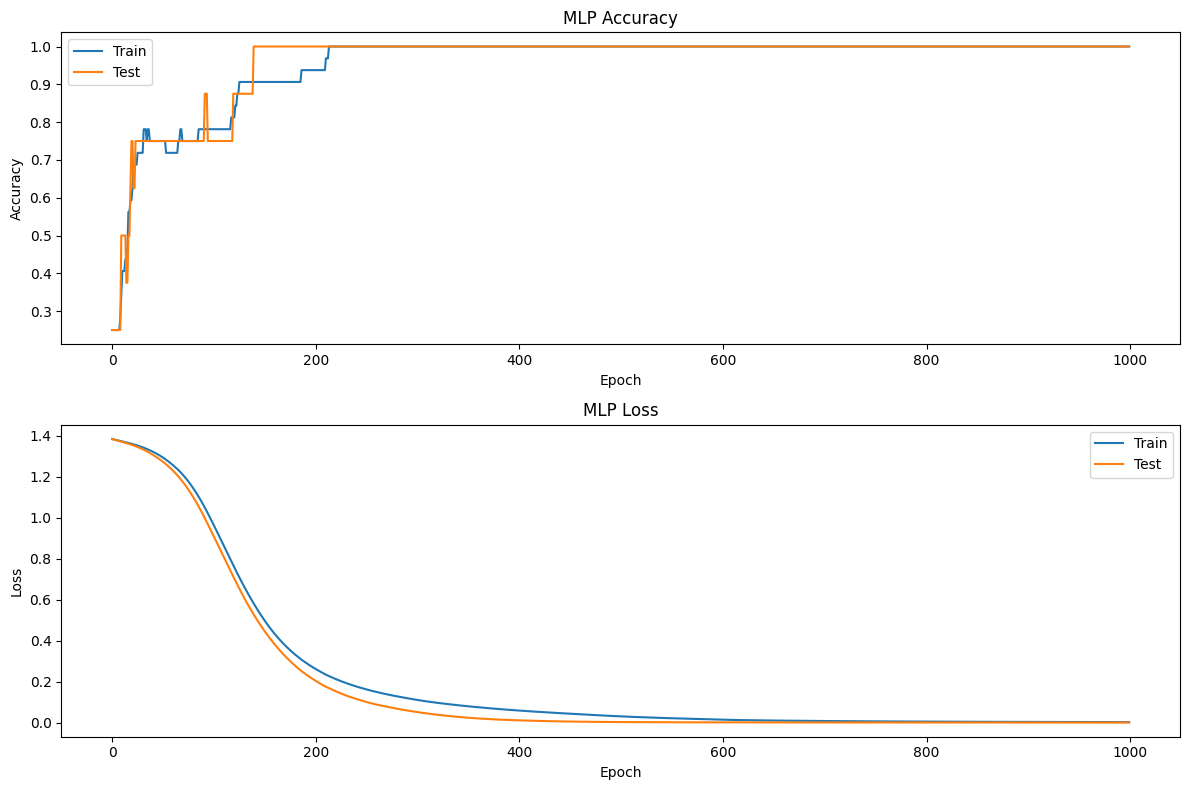

In [39]:

# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(mlp_logs['train_accs'], label='Train')
axs_plot[0].plot(mlp_logs['test_accs'], label='Test')
axs_plot[0].set_title('MLP Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(mlp_logs['train_losses'], label='Train')
axs_plot[1].plot(mlp_logs['test_losses'], label='Test')
axs_plot[1].set_title('MLP Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

In [40]:
# Create a mesh grid over the input space
xx, yy = np.meshgrid(
    np.linspace(data[:, 0].min() - 0.1, data[:, 0].max() + 0.1, 300),
    np.linspace(data[:, 1].min() - 0.1, data[:, 1].max() + 0.1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).type(dtype).to(device)


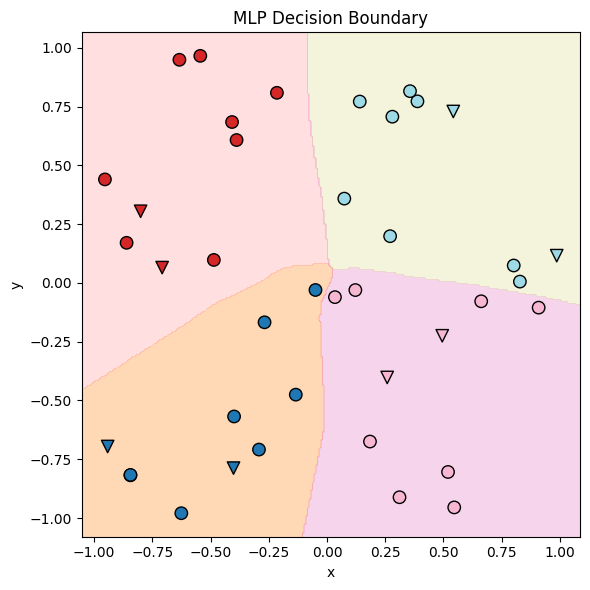

In [41]:
# Evaluate kan_layerwise on the grid
mlp.eval()
with torch.no_grad():
    mlp_pred = mlp(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, mlp_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('MLP Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [42]:
kan = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k, #seed=0,
    #init_mode='kaiming_in',
    base_fun=args.base_fun,
    )
print("KAN")
print(kan)

_ = kan(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0
KAN
MultKAN(
  (act_fun): ModuleList(
    (0-5): 6 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-5): 6 x Symbolic_KANLayer()
  )
)


tensor([[-0.0052,  0.0099,  0.0289, -0.0103],
        [-0.0051,  0.0102,  0.0289, -0.0100],
        [-0.0050,  0.0104,  0.0287, -0.0099],
        [-0.0046,  0.0116,  0.0281, -0.0095],
        [-0.0050,  0.0103,  0.0288, -0.0100],
        [-0.0048,  0.0110,  0.0284, -0.0097],
        [-0.0051,  0.0103,  0.0287, -0.0101],
        [-0.0053,  0.0096,  0.0291, -0.0105],
        [-0.0046,  0.0117,  0.0280, -0.0095],
        [-0.0053,  0.0097,  0.0290, -0.0104],
        [-0.0050,  0.0106,  0.0286, -0.0100],
        [-0.0050,  0.0104,  0.0287, -0.0101],
        [-0.0049,  0.0107,  0.0285, -0.0099],
        [-0.0050,  0.0105,  0.0286, -0.0099],
        [-0.0050,  0.0102,  0.0288, -0.0100],
        [-0.0050,  0.0105,  0.0287, -0.0100],
        [-0.0046,  0.0116,  0.0281, -0.0095],
        [-0.0052,  0.0099,  0.0289, -0.0103],
        [-0.0050,  0.0105,  0.0287, -0.0099],
        [-0.0045,  0.0120,  0.0279, -0.0094],
        [-0.0049,  0.0106,  0.0286, -0.0099],
        [-0.0051,  0.0102,  0.0289

In [43]:
# Train KAN
kan_opt = torch.optim.Adam(kan.parameters(), lr=args.learning_rate)
kan_logs = train_model(kan, kan_opt, dataset, n_epochs=n_epochs)

Epoch 1/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.387 | Test Loss: 1.387
Epoch 10/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.386 | Test Loss: 1.386
Epoch 10/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.386 | Test Loss: 1.386
Epoch 20/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.386 | Test Loss: 1.386
Epoch 20/1000 | Train Acc: 0.250 | Test Acc: 0.250 | Train Loss: 1.386 | Test Loss: 1.386
Epoch 30/1000 | Train Acc: 0.500 | Test Acc: 0.500 | Train Loss: 1.385 | Test Loss: 1.385
Epoch 30/1000 | Train Acc: 0.500 | Test Acc: 0.500 | Train Loss: 1.385 | Test Loss: 1.385
Epoch 40/1000 | Train Acc: 0.500 | Test Acc: 0.625 | Train Loss: 1.381 | Test Loss: 1.382
Epoch 40/1000 | Train Acc: 0.500 | Test Acc: 0.625 | Train Loss: 1.381 | Test Loss: 1.382
Epoch 50/1000 | Train Acc: 0.469 | Test Acc: 0.625 | Train Loss: 1.371 | Test Loss: 1.371
Epoch 50/1000 | Train Acc: 0.469 | Test Acc: 0.625 | Train Loss: 1.371 | Test Loss: 1.371
Epoch 60/10

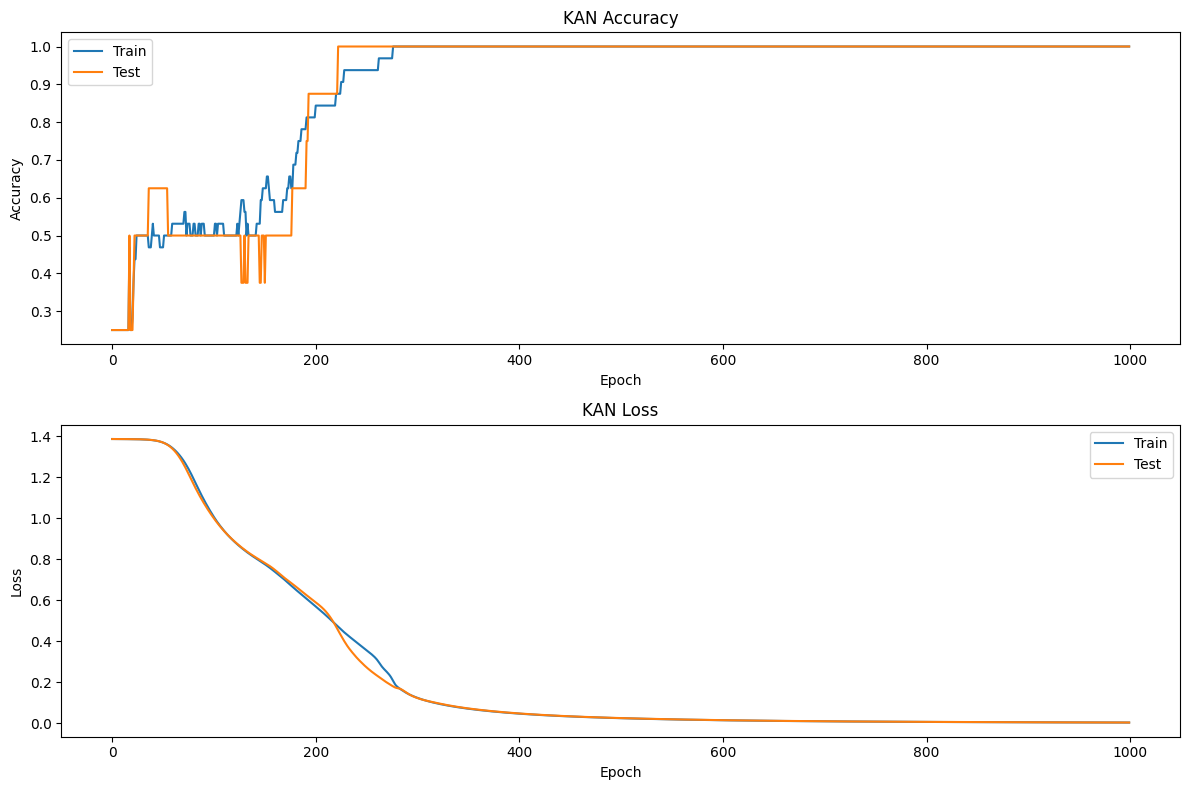

In [44]:
# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(kan_logs['train_accs'], label='Train')
axs_plot[0].plot(kan_logs['test_accs'], label='Test')
axs_plot[0].set_title('KAN Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(kan_logs['train_losses'], label='Train')
axs_plot[1].plot(kan_logs['test_losses'], label='Test')
axs_plot[1].set_title('KAN Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

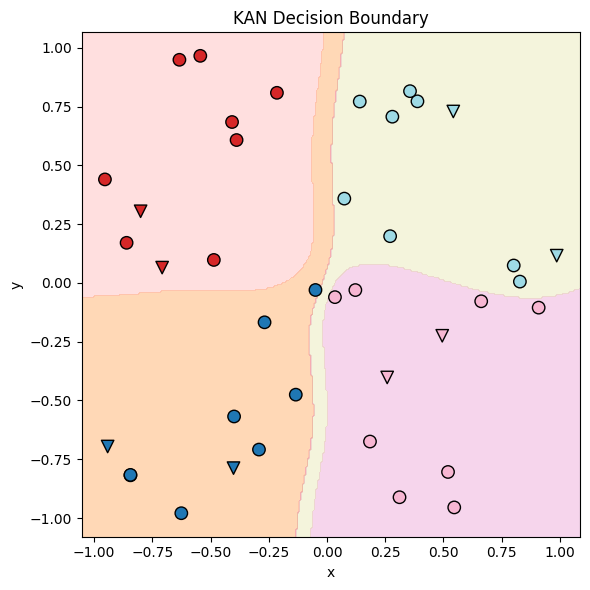

In [45]:
# Evaluate kan_layerwise on the grid
kan.eval()
with torch.no_grad():
    kan_pred = kan(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, kan_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('KAN Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [46]:
for i, preacts in enumerate(kan.spline_preacts):
    print(f"Layer {i}: Preactivation shape: {preacts.shape}")

Layer 0: Preactivation shape: torch.Size([90000, 5, 2])
Layer 1: Preactivation shape: torch.Size([90000, 5, 5])
Layer 2: Preactivation shape: torch.Size([90000, 5, 5])
Layer 3: Preactivation shape: torch.Size([90000, 5, 5])
Layer 4: Preactivation shape: torch.Size([90000, 5, 5])
Layer 5: Preactivation shape: torch.Size([90000, 4, 5])


Layer 1: 2 components for 90% variance, 2 components for 95% variance
Layer 2: 2 components for 90% variance, 2 components for 95% variance
Layer 3: 2 components for 90% variance, 2 components for 95% variance
Layer 4: 1 components for 90% variance, 1 components for 95% variance
Layer 5: 1 components for 90% variance, 1 components for 95% variance
Layer 6: 2 components for 90% variance, 2 components for 95% variance


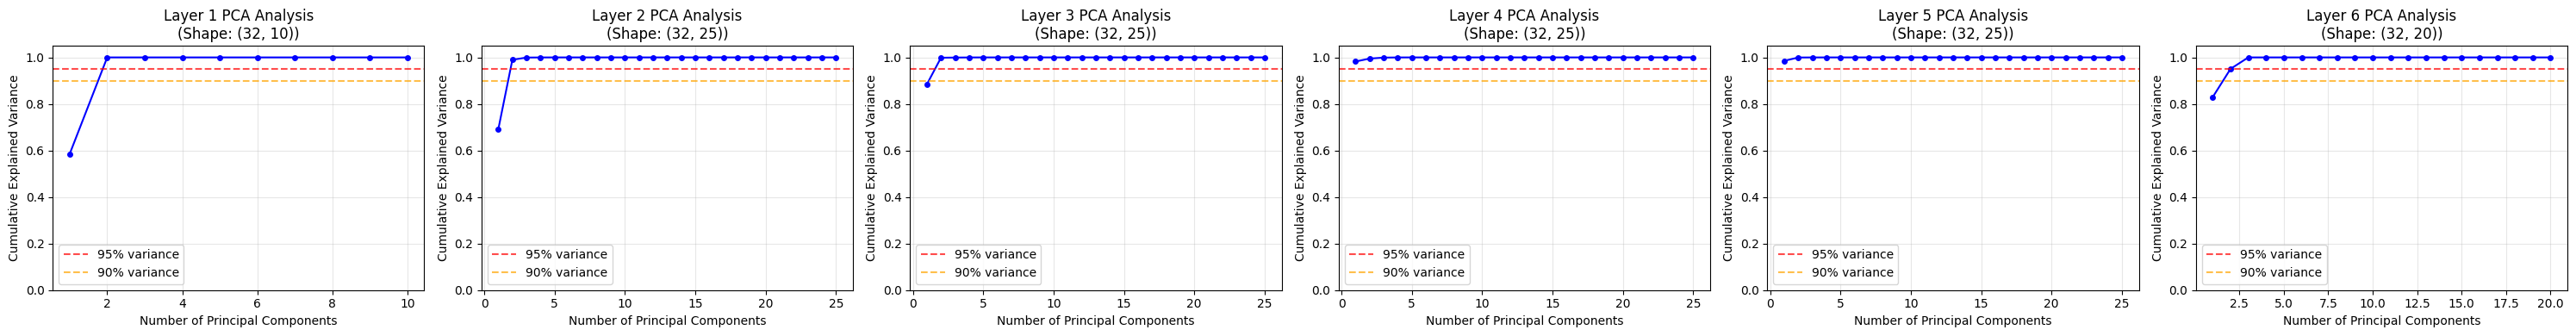

In [47]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Get activations for each layer by doing a forward pass
kan.eval()
with torch.no_grad():
    # Forward pass to populate spline_preacts
    _ = kan(dataset['train_input'])
    
    # Analyze each layer's activations
    n_layers = len(kan.spline_preacts)
    fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4))
    
    if n_layers == 1:
        axes = [axes]  # Make it iterable for single layer case
    
    for i, preacts in enumerate(kan.spline_preacts):
        # Convert to numpy and reshape if needed
        activations = preacts.cpu().numpy()
        
        # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
        if len(activations.shape) == 3:
            batch_size, input_dim, output_dim = activations.shape
            activations = activations.reshape(batch_size, -1)
        
        # Perform PCA
        pca = PCA()
        pca.fit(activations)
        
        # Calculate cumulative explained variance ratio
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        
        # Plot
        axes[i].plot(range(1, len(cumvar) + 1), cumvar, 'bo-', markersize=4)
        axes[i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
        axes[i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
        axes[i].set_xlabel('Number of Principal Components')
        axes[i].set_ylabel('Cumulative Explained Variance')
        axes[i].set_title(f'Layer {i+1} PCA Analysis\n(Shape: {activations.shape})')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        axes[i].set_ylim(0, 1.05)
        
        # Find number of components for 90% and 95% variance
        n_95 = np.argmax(cumvar >= 0.95) + 1
        n_90 = np.argmax(cumvar >= 0.90) + 1
        
        print(f"Layer {i+1}: {n_90} components for 90% variance, {n_95} components for 95% variance")
    
    plt.tight_layout()
    plt.show()

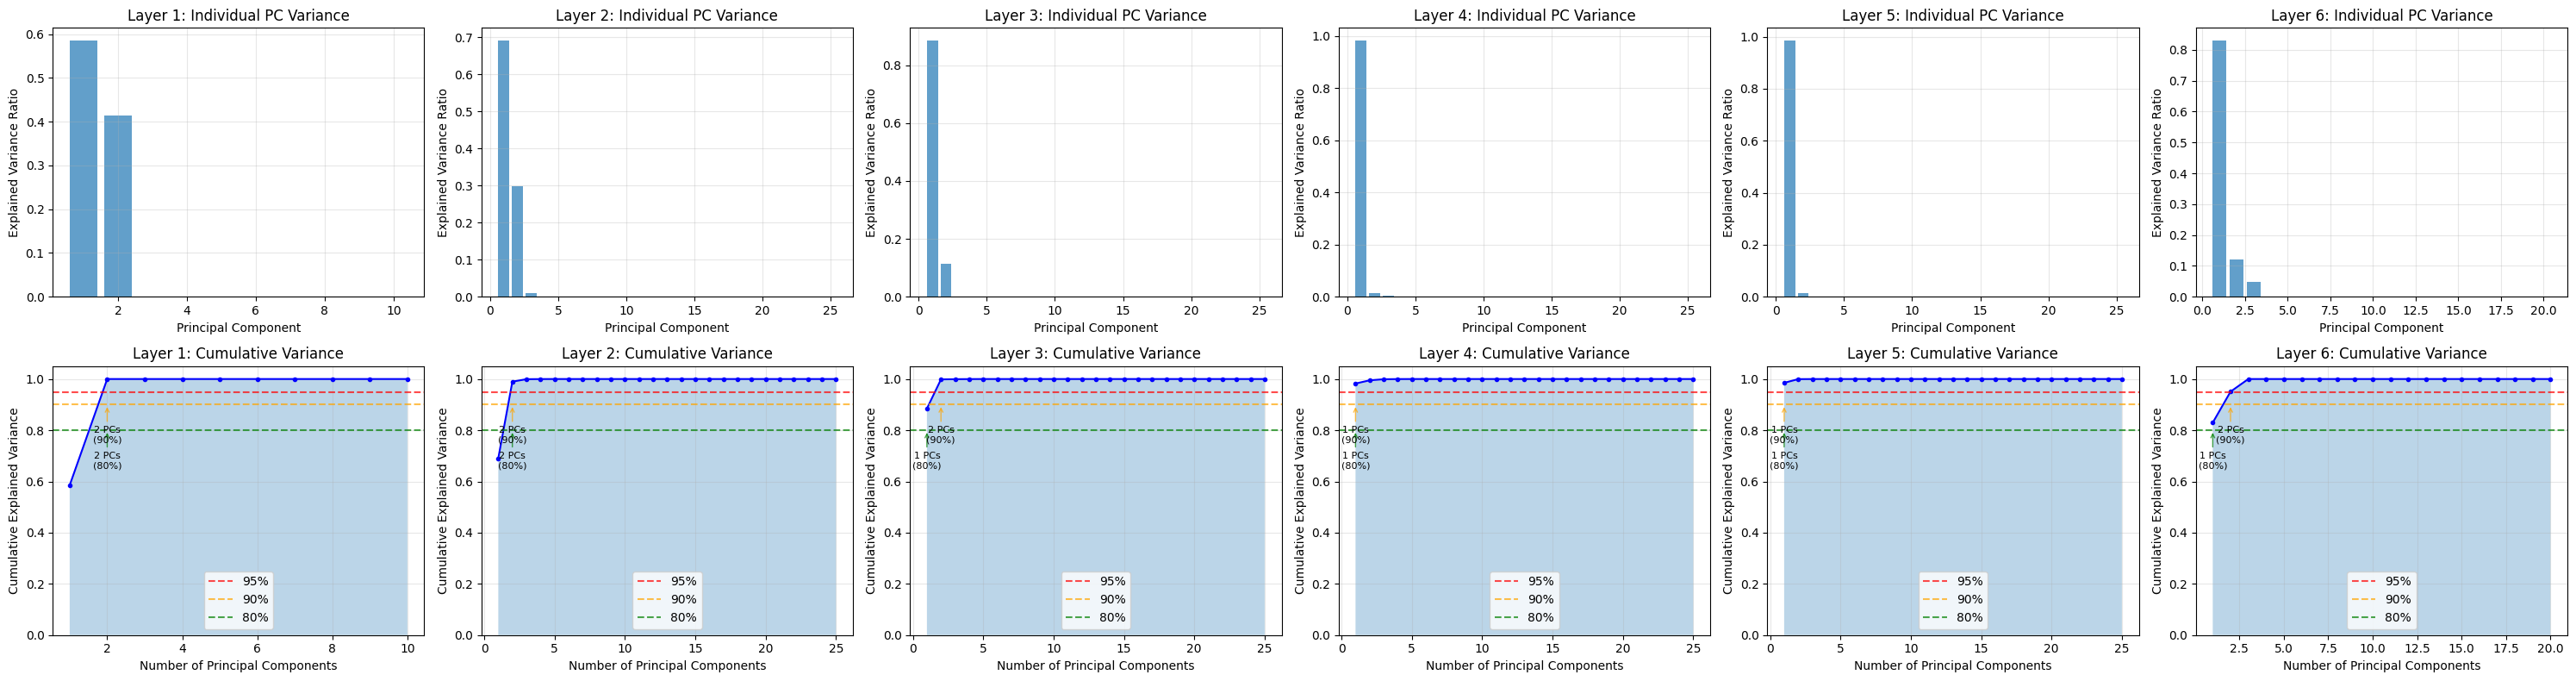

In [48]:
# Create a more detailed analysis showing individual component contributions
fig, axes = plt.subplots(2, n_layers, figsize=(5 * n_layers, 8))

if n_layers == 1:
    axes = axes.reshape(2, 1)  # Make it 2D for single layer case

for i, preacts in enumerate(kan.spline_preacts):
    # Convert to numpy and reshape if needed
    activations = preacts.cpu().numpy()
    
    # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
    if len(activations.shape) == 3:
        batch_size, input_dim, output_dim = activations.shape
        activations = activations.reshape(batch_size, -1)
    
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    # Plot individual component variance ratios
    axes[0, i].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                   pca.explained_variance_ratio_, alpha=0.7)
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_ylabel('Explained Variance Ratio')
    axes[0, i].set_title(f'Layer {i+1}: Individual PC Variance')
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot cumulative variance with more detail
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[1, i].plot(range(1, len(cumvar) + 1), cumvar, 'bo-', markersize=3)
    axes[1, i].fill_between(range(1, len(cumvar) + 1), cumvar, alpha=0.3)
    axes[1, i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[1, i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
    axes[1, i].axhline(y=0.80, color='green', linestyle='--', alpha=0.7, label='80%')
    axes[1, i].set_xlabel('Number of Principal Components')
    axes[1, i].set_ylabel('Cumulative Explained Variance')
    axes[1, i].set_title(f'Layer {i+1}: Cumulative Variance')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()
    axes[1, i].set_ylim(0, 1.05)
    
    # Add text annotations for key thresholds
    n_80 = np.argmax(cumvar >= 0.80) + 1
    n_90 = np.argmax(cumvar >= 0.90) + 1
    n_95 = np.argmax(cumvar >= 0.95) + 1
    
    axes[1, i].annotate(f'{n_80} PCs\n(80%)', 
                        xy=(n_80, 0.80), xytext=(n_80, 0.65),
                        arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                        ha='center', fontsize=8)
    axes[1, i].annotate(f'{n_90} PCs\n(90%)', 
                        xy=(n_90, 0.90), xytext=(n_90, 0.75),
                        arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
                        ha='center', fontsize=8)

plt.tight_layout()
plt.show()

PCA Analysis Summary for KAN Layers:
  Layer Activation Shape  Total Components  PCs for 80%  PCs for 90%  PCs for 95%  PCs for 99% Top PC Variance Compression 90% Compression 95%
Layer 1         (32, 10)                10            2            2            2            2           0.585          20.00%          20.00%
Layer 2         (32, 25)                25            2            2            2            3           0.691           8.00%           8.00%
Layer 3         (32, 25)                25            1            2            2            2           0.885           8.00%           8.00%
Layer 4         (32, 25)                25            1            1            1            2           0.982           4.00%           4.00%
Layer 5         (32, 25)                25            1            1            1            2           0.985           4.00%           4.00%
Layer 6         (32, 20)                20            1            2            2            3           

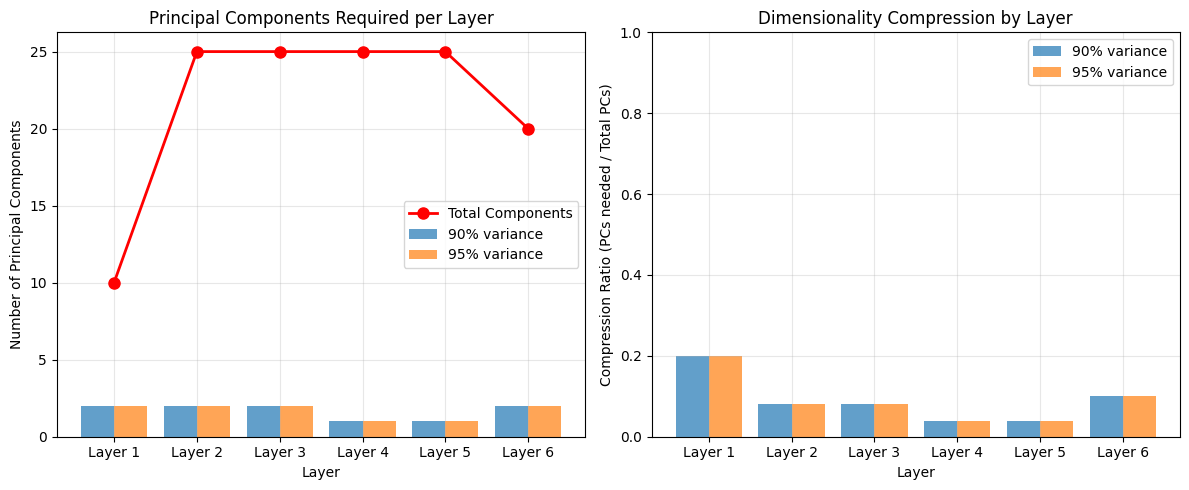

In [49]:
# Create a summary table of PCA results
import pandas as pd

summary_data = []
for i, preacts in enumerate(kan.spline_preacts):
    # Convert to numpy and reshape if needed
    activations = preacts.cpu().numpy()
    
    # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
    if len(activations.shape) == 3:
        batch_size, input_dim, output_dim = activations.shape
        activations = activations.reshape(batch_size, -1)
    
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    
    # Calculate statistics
    n_total_components = len(pca.explained_variance_ratio_)
    n_80 = np.argmax(cumvar >= 0.80) + 1 if np.any(cumvar >= 0.80) else n_total_components
    n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else n_total_components
    n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else n_total_components
    n_99 = np.argmax(cumvar >= 0.99) + 1 if np.any(cumvar >= 0.99) else n_total_components
    
    # Top component contribution
    max_component_var = pca.explained_variance_ratio_[0]
    
    summary_data.append({
        'Layer': f'Layer {i+1}',
        'Activation Shape': f'{activations.shape}',
        'Total Components': n_total_components,
        'PCs for 80%': n_80,
        'PCs for 90%': n_90,
        'PCs for 95%': n_95,
        'PCs for 99%': n_99,
        'Top PC Variance': f'{max_component_var:.3f}',
        'Compression 90%': f'{n_90/n_total_components:.2%}',
        'Compression 95%': f'{n_95/n_total_components:.2%}'
    })

summary_df = pd.DataFrame(summary_data)
print("PCA Analysis Summary for KAN Layers:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Also create a visualization of the compression ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

layers = [f'Layer {i+1}' for i in range(len(kan.spline_preacts))]
pcs_90 = summary_df['PCs for 90%'].values
pcs_95 = summary_df['PCs for 95%'].values
total_pcs = summary_df['Total Components'].values

# Plot absolute number of components needed
ax1.bar([i-0.2 for i in range(len(layers))], pcs_90, 0.4, label='90% variance', alpha=0.7)
ax1.bar([i+0.2 for i in range(len(layers))], pcs_95, 0.4, label='95% variance', alpha=0.7)
ax1.plot(range(len(layers)), total_pcs, 'ro-', label='Total Components', linewidth=2, markersize=8)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Number of Principal Components')
ax1.set_title('Principal Components Required per Layer')
ax1.set_xticks(range(len(layers)))
ax1.set_xticklabels(layers)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot compression ratios
compression_90 = pcs_90 / total_pcs
compression_95 = pcs_95 / total_pcs

ax2.bar([i-0.2 for i in range(len(layers))], compression_90, 0.4, label='90% variance', alpha=0.7)
ax2.bar([i+0.2 for i in range(len(layers))], compression_95, 0.4, label='95% variance', alpha=0.7)
ax2.set_xlabel('Layer')
ax2.set_ylabel('Compression Ratio (PCs needed / Total PCs)')
ax2.set_title('Dimensionality Compression by Layer')
ax2.set_xticks(range(len(layers)))
ax2.set_xticklabels(layers)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()